# 1. Libraries

In [88]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


# 2. Preperation

In [89]:
df = pd.read_csv('df_imputed.csv')
df.dropna(inplace=True)
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,normal,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,normal,normal,notpresent,notpresent,94.0,...,38.0,6000.0,4.3,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,4.2,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


In [90]:
categorical = df.select_dtypes(exclude=np.number)
a = df.info(verbose=True)

print(a)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     349 non-null    float64
 1   bp      349 non-null    float64
 2   sg      349 non-null    float64
 3   al      349 non-null    float64
 4   su      349 non-null    float64
 5   rbc     349 non-null    object 
 6   pc      349 non-null    object 
 7   pcc     349 non-null    object 
 8   ba      349 non-null    object 
 9   bgr     349 non-null    float64
 10  bu      349 non-null    float64
 11  sc      349 non-null    float64
 12  sod     349 non-null    float64
 13  pot     349 non-null    float64
 14  hemo    349 non-null    float64
 15  pcv     349 non-null    float64
 16  wbcc    349 non-null    float64
 17  rbcc    349 non-null    float64
 18  htn     349 non-null    object 
 19  dm      349 non-null    object 
 20  cad     349 non-null    object 
 21  appet   349 non-null    object 
 22  pe

In [91]:
# Preprocessing
# Convert categorical features to numerical features
label_encoders = {}
for cat_col in df.select_dtypes(include=['object']).columns:
    label_encoders[cat_col] = LabelEncoder()
    df[cat_col] = label_encoders[cat_col].fit_transform(df[cat_col])

# Standardize numerical features
scaler = StandardScaler()
df[df.select_dtypes(include=['float64']).columns] = scaler.fit_transform(df[df.select_dtypes(include=['float64']).columns])


In [92]:
a = df_encoded.info(verbose=True)

print(a)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 37 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             349 non-null    float64
 1   bp              349 non-null    float64
 2   sg              349 non-null    float64
 3   al              349 non-null    float64
 4   su              349 non-null    float64
 5   bgr             349 non-null    float64
 6   bu              349 non-null    float64
 7   sc              349 non-null    float64
 8   sod             349 non-null    float64
 9   pot             349 non-null    float64
 10  hemo            349 non-null    float64
 11  pcv             349 non-null    float64
 12  wbcc            349 non-null    float64
 13  rbcc            349 non-null    float64
 14  rbc_abnormal    349 non-null    uint8  
 15  rbc_normal      349 non-null    uint8  
 16  pc_abnormal     349 non-null    uint8  
 17  pc_normal       349 non-null    uin

In [93]:

# Split data into training, validation and testing sets
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

class CKDDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data.drop(columns='class').values, dtype=torch.float32)
        self.targets = torch.tensor(data['class'].values, dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

# Create DataLoaders
train_dataset = CKDDataset(train_df)
train_loader = DataLoader(train_dataset, batch_size=16)

val_dataset = CKDDataset(val_df)
val_loader = DataLoader(val_dataset, batch_size=16)

test_dataset = CKDDataset(test_df)
test_loader = DataLoader(test_dataset, batch_size=16)

# 3. Model Creation

In [94]:
# Define the network architecture
class Net(nn.Module):  # We define our model as a subclass of torch.nn.Module.
    def __init__(self):  # This is the constructor of our class where we define our layers.
        super(Net, self).__init__()  # We call the constructor of the superclass (nn.Module) to initialize it.

        # Define fully connected layers (fc stands for fully connected). 
        # nn.Linear is a standard linear (affine) layer with weights and bias. 

        self.fc1 = nn.Linear(24, 24)  # First layer takes 24 inputs (this should be equal to the number of features in your data) and outputs 128 features.
        self.fc2 = nn.Linear(24, 24)  # Second layer takes 128 inputs (from previous layer) and outputs 64 features.
        self.fc3 = nn.Linear(24, 2)  # Third layer takes 64 inputs (from previous layer) and outputs 2 features (this should be equal to the number of classes in your data).

    def forward(self, x):  # This method defines the forward pass of the network. PyTorch will automatically create the backward pass for you.
        x = torch.relu(self.fc1(x))  # Apply the first layer to the input, then apply the ReLU activation function.
        x = torch.relu(self.fc2(x))  # Apply the second layer to the result of the previous operation, then apply the ReLU activation function.
        x = self.fc3(x)  # Apply the third layer to the result of the previous operation. Note we don't apply an activation here because it's included in the CrossEntropyLoss function.
        return x  # The result of the last operation is returned as the output of the network.


In [95]:
# Initialize the model, optimizer, and loss function
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# 4. Training

In [96]:
# Training
n_epochs = 3
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(n_epochs):
    train_loss = 0
    val_loss = 0
    train_correct = 0
    val_correct = 0
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == targets).sum().item()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # The model is set to evaluation mode. In this mode, operations such as dropout are disabled.
    model.eval()

    # Disable gradient computations (they are not needed in evaluation mode and consume memory)
    with torch.no_grad():
        # Iterate over the validation set
        for inputs, targets in val_loader:
            # Generate predictions by passing the inputs through the model
            outputs = model(inputs)
            # The output of the model is a vector of logits for each class. To get the predicted class, we find the index (class) with the maximum logit.
            _, predicted = torch.max(outputs.data, 1)
            # Compare the predictions to the true labels, the sum of the comparisons gives the number of correct predictions
            val_correct += (predicted == targets).sum().item()
            # Compute the loss for this batch
            loss = criterion(outputs, targets)
            # Add the loss to the total validation loss (we'll take the average later)
            val_loss += loss.item()

    # The total losses stored were summed over all batches. To get the average loss per item, we divide by the total number of items.
    # The same applies for the accuracy. We divide the number of correct predictions by the total number of items to get the accuracy.
    train_loss /= len(train_dataset)
    val_loss /= len(val_dataset)
    train_acc = train_correct / len(train_dataset)
    val_acc = val_correct / len(val_dataset)

    # Store the average losses and accuracies for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # Print the losses and accuracies for this epoch
    print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.3f}, Validation Loss: {val_loss:.3f}, Train Accuracy: {train_acc:.3f}, Validation Accuracy: {val_acc:.3f}')
   

Epoch 1/3, Train Loss: 0.041, Validation Loss: 0.047, Train Accuracy: 0.881, Validation Accuracy: 0.846
Epoch 2/3, Train Loss: 0.036, Validation Loss: 0.042, Train Accuracy: 0.955, Validation Accuracy: 0.942
Epoch 3/3, Train Loss: 0.031, Validation Loss: 0.035, Train Accuracy: 0.971, Validation Accuracy: 0.942


# 5. Evaluation

In [97]:
# Evaluation
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for inputs, targets in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predictions += list(predicted.numpy())
        true_labels += list(targets.numpy())

# Compute evaluation metrics
print(confusion_matrix(true_labels, predictions))
print(classification_report(true_labels, predictions, target_names=['ckd', 'notckd']))

[[33  3]
 [ 0 16]]
              precision    recall  f1-score   support

         ckd       1.00      0.92      0.96        36
      notckd       0.84      1.00      0.91        16

    accuracy                           0.94        52
   macro avg       0.92      0.96      0.94        52
weighted avg       0.95      0.94      0.94        52



# 6. Visualizing the performance

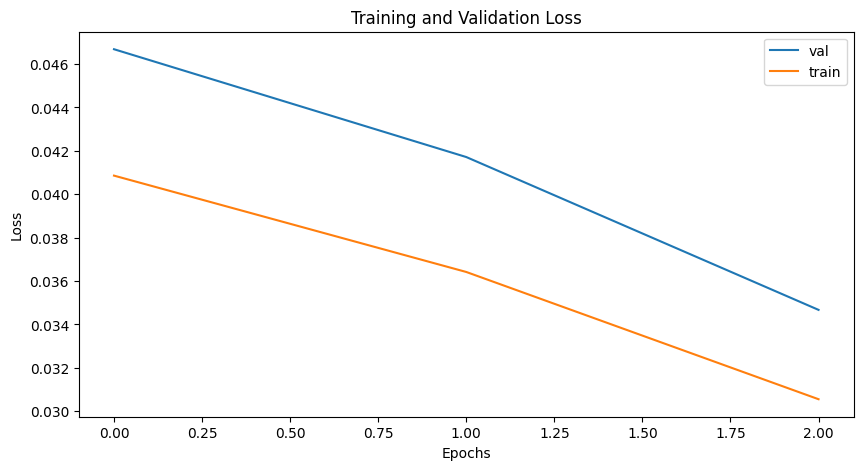

In [98]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.plot(val_losses, label="val")
plt.plot(train_losses, label="train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


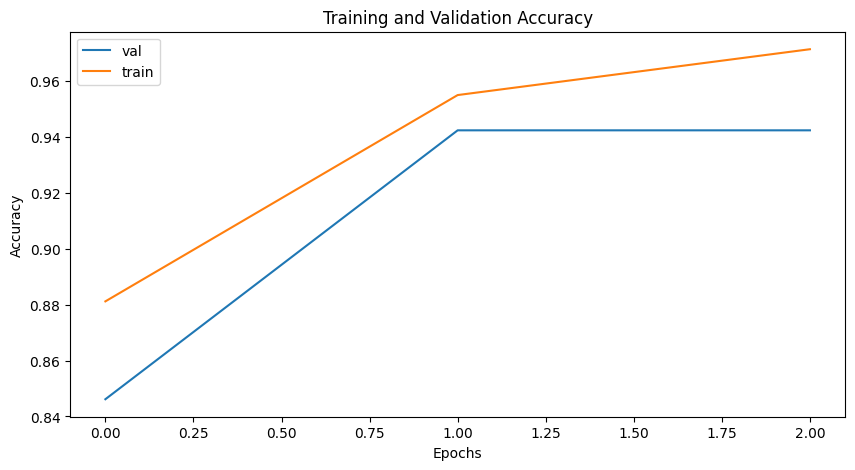

In [99]:

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Accuracy")
plt.plot(val_accuracies, label="val")
plt.plot(train_accuracies, label="train")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


# 7. evaluate on the test set

In [100]:
# Evaluation on test set
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predictions += list(predicted.numpy())
        true_labels += list(targets.numpy())

# Compute evaluation metrics
print(confusion_matrix(true_labels, predictions))
print(classification_report(true_labels, predictions, target_names=['ckd', 'notckd']))

[[37  2]
 [ 0 14]]
              precision    recall  f1-score   support

         ckd       1.00      0.95      0.97        39
      notckd       0.88      1.00      0.93        14

    accuracy                           0.96        53
   macro avg       0.94      0.97      0.95        53
weighted avg       0.97      0.96      0.96        53

